Now we are on the data preparation stage. So far we have removed all the bad ride requests and now we are left with good ride requests only.

In [2]:
import sys
!{sys.executable} -m pip install gpxpy

     |████████████████████████████████| 111 kB 3.8 MB/s eta 0:00:01
  Created wheel for gpxpy: filename=gpxpy-1.5.0-py3-none-any.whl size=42898 sha256=fe7a526039bb7136b167eb7e48f9fb042d2edef842529edbb8e9141ed7655f12
  Stored in directory: /Users/artem/Library/Caches/pip/wheels/7e/9b/8d/b4812540cd01add3ca698dc5903c53b99d15ffbd61f23fdf0a
Successfully built gpxpy


In [7]:
# Import libraries
import pandas as pd
import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt
from sklearn.cluster import MiniBatchKMeans, KMeans
import gpxpy.geo
from datetime import datetime, timedelta
from joblib import dump, load
import pandas_profiling
from IPython.display import display

In [6]:
df = pd.read_csv("../../output/clean_data.csv", compression="gzip", parse_dates=["ts"])

In [8]:
print(df.shape)
display(df.head())

(3707659, 16)


,ts,number,pick_lat,pick_lng,drop_lat,drop_lng,geodesic_distance,hour,minute,day,month,year,dayofweek,booking_timestamp,booking_time_diff_hr,booking_time_diff_min
0,2020-10-10 07:34:16,-1.0,12.975773,77.57107,12.878468,77.445330,17.38,7,34,10,10,2020,5,1602315256,445087,26705254
1,2020-10-11 08:23:42,-1.0,12.930813,77.60953,12.960320,77.587210,4.06,8,23,11,10,2020,6,1602404622,24,1489
2,2020-10-11 11:57:17,-1.0,12.960213,77.58746,12.930824,77.609610,4.04,11,57,11,10,2020,6,1602417437,3,213
3,2020-10-16 17:51:07,-1.0,12.924353,77.54941,12.932216,77.581825,3.62,17,51,16,10,2020,4,1602870667,125,7553
4,2020-10-30 09:00:44,-1.0,12.945731,77.62250,12.973030,77.616840,3.08,9,0,30,10,2020,4,1604048444,327,19629


In [9]:
print(f"Number of good ride requests: {df.shape[0]}")

Number of good ride requests: 3707659


Now, we are going to perform geospatial engineering because our (latitude and longitude) values for (pick up and drop off) locations cannot be directly fed into any model. 

Geospatial engineering will consists of performing clustering on pick_lat/pick_lng to identify from which region the demand is coming from.

For clustering we will be using a little variant of K-Means algorithm which is the Mini-Batch K-Means algorithm. Difference between these two algorithms is that in Mini-Batch K-Means algorithm will be taking small random batches of input data of a fixed size, so that at each iteration a new random sample from the input data is obtained and used to update the clusters and this is repeated until convergence. 

Consequently, using this approach will drastically reduce the computation time. If we would have been using the standard K-Means algorithm on 3707659 entries, it would have taken hours and hours to converge. 

Furthermore, we are going to perform several Mini-Batch K-Means clusterings on 10 different cluster sizes: (10, 20, 30, 40, 50, 60, 70, 80, 90)

In [11]:
coord = df[["pick_lat", "pick_lng"]].values
neighbors = []

In [12]:
def min_distance(regionCenters, totalClusters):
    good_points = 0
    bad_points = 0
    less_dist = []
    more_dist = []
    min_distance = np.inf  #any big number can be given here
    for i in range(totalClusters):
        good_points = 0
        bad_points = 0
        for j in range(totalClusters):
            if j != i:
                distance = gpxpy.geo.haversine_distance(latitude_1 = regionCenters[i][0], longitude_1 = regionCenters[i][1], latitude_2 = regionCenters[j][0], longitude_2 = regionCenters[j][1])
                distance = distance/(1.60934*1000)   #distance from meters to miles
                min_distance = min(min_distance, distance) #it will return minimum of "min_distance, distance".
                if distance < 2:
                    good_points += 1
                else:
                    bad_points += 1
        less_dist.append(good_points)
        more_dist.append(bad_points)
    print("On choosing a cluster size of {}".format(totalClusters))
    print("Avg. Number clusters within vicinity where inter cluster distance < 2 miles is {}".format(np.ceil(sum(less_dist)/len(less_dist))))
    print("Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is {}".format(np.ceil(sum(more_dist)/len(more_dist))))
    print("Minimum distance between any two clusters = {}".format(min_distance))
    print("-"*10)
            
def makingRegions(noOfRegions):
    regions = MiniBatchKMeans(n_clusters = noOfRegions, batch_size = 10000, random_state = 5).fit(coord)
    regionCenters = regions.cluster_centers_ 
    totalClusters = len(regionCenters)
    return regionCenters, totalClusters

In [14]:
startTime = datetime.now()
for i in range(10, 100, 10):
    regionCenters, totalClusters = makingRegions(i)
    min_distance(regionCenters, totalClusters)
print("Time taken = "+str(datetime.now() - startTime))

On choosing a cluster size of 10
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 0.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 9.0
Minimum distance between any two clusters = 2.588823301670754
----------
On choosing a cluster size of 20
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 1.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 18.0
Minimum distance between any two clusters = 1.0308088177636452
----------
On choosing a cluster size of 30
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 2.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 28.0
Minimum distance between any two clusters = 0.8973005516852949
----------
On choosing a cluster size of 40
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 3.0
Avg. Number clusters outside of vicinity where inter

We performed 9 clusterings with different cluster sizes using Mini-Batch K-Means algorithm and we still got a very computation time of only 11 seconds for this entire clustering on 9 different cluster sizes. So, you can see how fast is Mini-Batch K-Means algorithm is. This is the reason why we're using the Mini-Batch K-Means algorithm.

Analysing results we decided to pick cluster size of 90 because it has the value of (0.5401172488306791) which the value closests to 0.5 because for Bangalore region that is the most operational zone for OLA.

Now, we are going to train our Mini-Batch K-Means algorithm:

In [50]:
coord = df[["pick_lat", "pick_lng"]].values
regions = MiniBatchKMeans(n_clusters=30, batch_size=10000, random_state=0).fit(coord)
df["pickup_cluster"] = regions.predict(df[["pick_lat", "pick_lng"]])

/Users/artem/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MiniBatchKMeans was fitted without feature names
  warnings.warn(


In [51]:
df.head(20)

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng,geodesic_distance,hour,minute,day,month,year,dayofweek,booking_timestamp,booking_time_diff_hr,booking_time_diff_min,pickup_cluster
0,2020-10-10 07:34:16,-1.0,12.975773,77.571070,12.878468,77.445330,17.38,7,34,10,10,2020,5,1602315256,445087,26705254,0
1,2020-10-11 08:23:42,-1.0,12.930813,77.609530,12.960320,77.587210,4.06,8,23,11,10,2020,6,1602404622,24,1489,8
2,2020-10-11 11:57:17,-1.0,12.960213,77.587460,12.930824,77.609610,4.04,11,57,11,10,2020,6,1602417437,3,213,26
3,2020-10-16 17:51:07,-1.0,12.924353,77.549410,12.932216,77.581825,3.62,17,51,16,10,2020,4,1602870667,125,7553,29
4,2020-10-30 09:00:44,-1.0,12.945731,77.622500,12.973030,77.616840,3.08,9,0,30,10,2020,4,1604048444,327,19629,14
5,2020-11-27 20:16:20,-1.0,13.031985,77.571280,12.960211,77.646910,11.42,20,16,27,11,2020,4,1606508180,683,40995,5
6,2020-11-27 20:35:09,-1.0,13.031940,77.571260,12.960211,77.646910,11.42,20,35,27,11,2020,4,1606509309,0,18,5
7,2020-12-05 22:09:55,-1.0,12.938531,77.578940,12.952660,77.568825,1.91,22,9,5,12,2020,5,1607206195,193,11614,16
8,2020-12-06 10:25:54,-1.0,12.933546,77.692894,12.977833,77.646830,7.00,10,25,6,12,2020,6,1607250354,12,735,25
9,2020-12-06 10:34:20,-1.0,12.933337,77.691180,12.977833,77.646830,6.88,10,34,6,12,2020,6,1607250860,0,8,25


Now, let's store the model to define pickup cluster given latitude and longitude in a joblib file:

In [52]:
import os
try:
    os.mkdir("../../output/models")
except:
    pass
dump(regions, "../../output/models/pickup_cluster_model.joblib", compress=3)

['../../output/models/pickup_cluster_model.joblib']

Now, let's perform clustering on the Bangalore region:

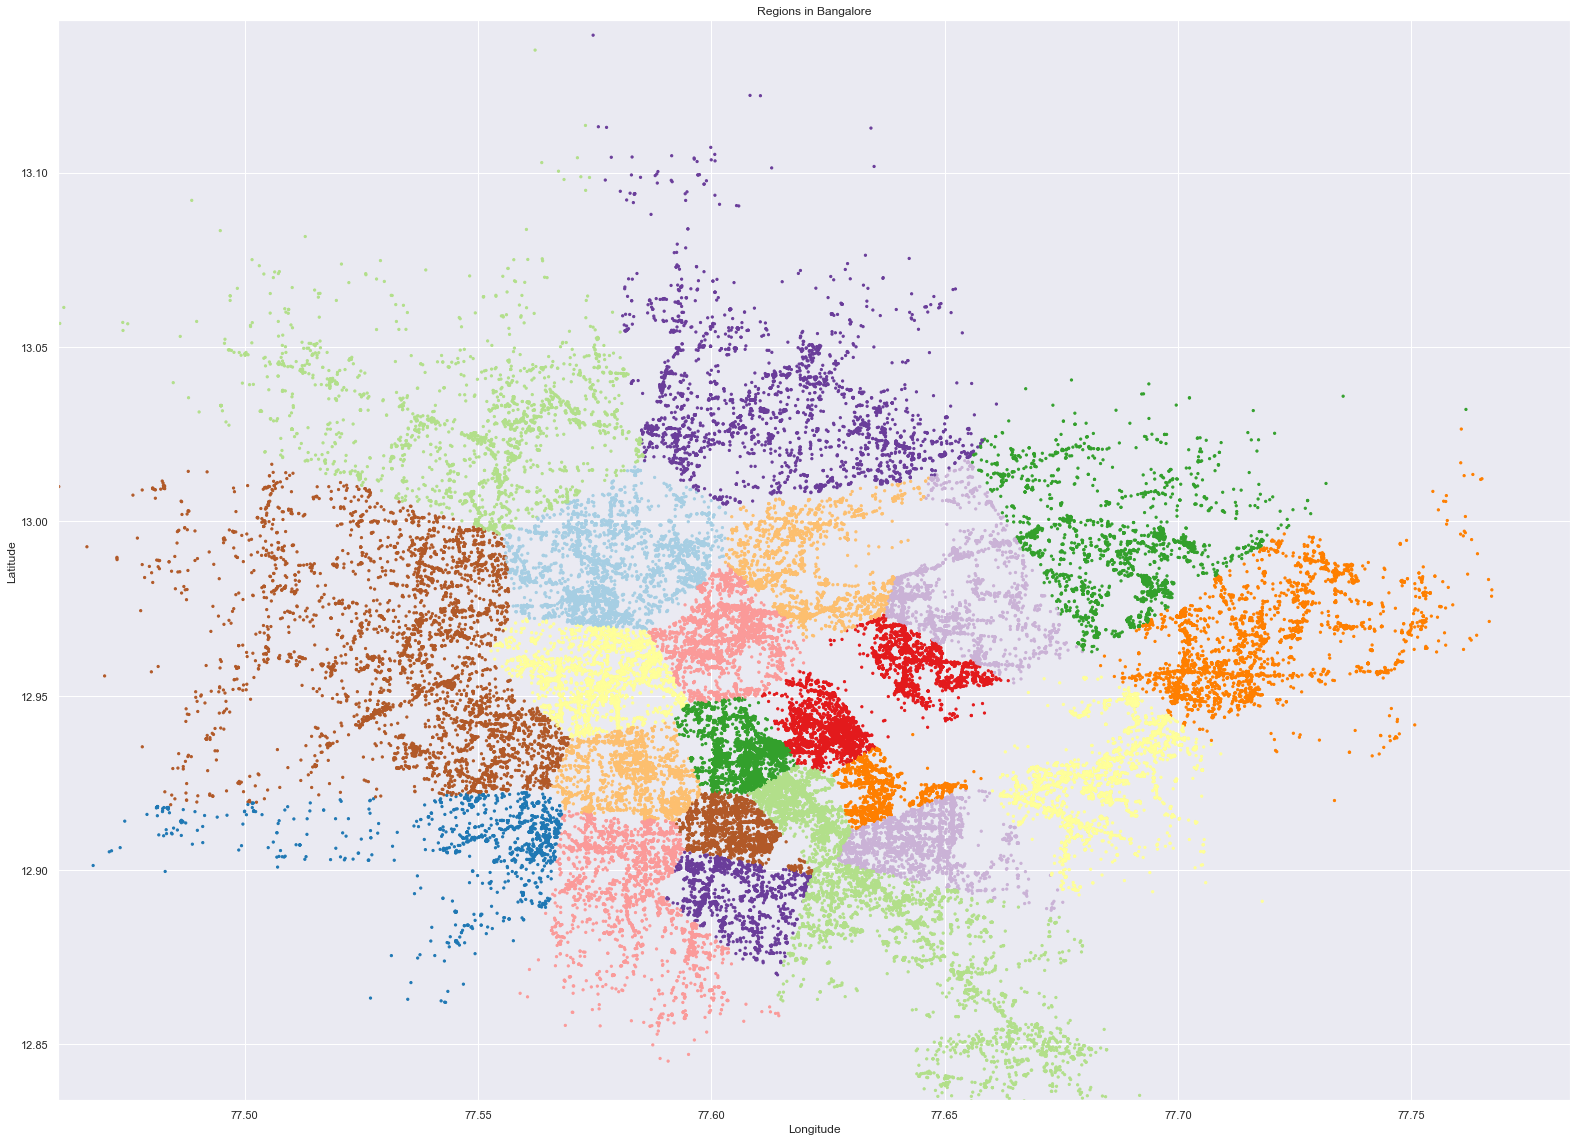

In [53]:
### These pickup clusters tell in which area most ride requests are coming. 
### Plotting Regions in Bangalore (our most rides requests here)
#### Bangalore:'boundingbox': ['12.8340125', '13.1436649', '77.4601025', '77.7840515']
bangalore_latitude_range = (12.8340125, 13.1436649)
bangalore_longitude_range = (77.4601025, 77.7840515)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.scatter(x = df["pick_lng"].values[:100000], y = df["pick_lat"].values[:100000], c = df["pickup_cluster"].values[:100000], cmap = "Paired", s = 5)
ax.set_xlim(bangalore_longitude_range[0], bangalore_longitude_range[1])
ax.set_ylim(bangalore_latitude_range[0], bangalore_latitude_range[1])
ax.set_title("Regions in Bangalore")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()
#Longitude values vary from left to right i.e., horizontally
#Latitude values vary from top to bottom means i.e., vertically

Text(0, 0.5, 'Latitude')

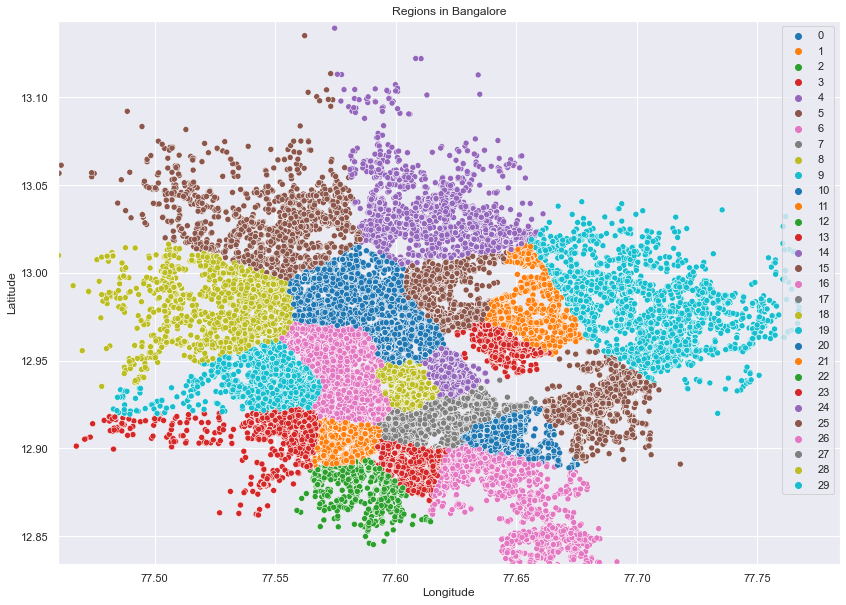

In [54]:
import seaborn as sns

### These pickup clusters tell in which area most ride requests are coming. 
### Plotting Regions in Bangalore (our most rides requests here)
#### Bangalore:'boundingbox': ['12.8340125', '13.1436649', '77.4601025', '77.7840515']
bangalore_latitude_range = (12.8340125, 13.1436649)
bangalore_longitude_range = (77.4601025, 77.7840515)

sns.set(rc={"figure.figsize":(14,10)})
p = sns.scatterplot(x=df["pick_lng"].values[:100000], y=df["pick_lat"].values[:100000], hue=df["pickup_cluster"].values[:100000], 
                    palette='tab10',
                    legend='brief'
)
p.set_xlim(bangalore_longitude_range[0], bangalore_longitude_range[1])
p.set_ylim(bangalore_latitude_range[0], bangalore_latitude_range[1])
p.set_title("Regions in Bangalore")
p.set_xlabel('Longitude')
p.set_ylabel('Latitude')
#Longitude values vary from left to right i.e., horizontally
#Latitude values vary from top to bottom means i.e., vertically

Now, we can see how the city of Bangalaore is divided into different clusters. 

For example, take the cyan zone - any ride request coming from this cyan zone we would predict demand forecast for this particular cyan zone - we will not do demand forecast for the entire city - we will be doing demand forecasts just for these small particular regions